<a href="https://colab.research.google.com/github/kylemath/eeg-notebooks/blob/master/notebooks/CueingGroupAnalysis_Colab_Winter2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CueingGroupAnalysis_Colab_Winter2019

The cueing task can ellicit a number of reliable changes. A central cue indicates the location of an upcoming target onset. Here the task can be changed to be perfectly predictive, or have some level of cue validity. Task is to indicate the orientation of a spatial grating on the target, up for vertical, right for horizontal.

ERP - Validly cued targets ellict larger ERP's than invalidly cued targets

Response ERPs - Validly cued targets are more quickly identified and better identified

Oscillations - Alpha power lateralizes after a spatial cue onset preceeding the upcoming onset of a target. Alpha power becomes smaller contraleral to the target side, and larger ipsilateral with the target.

In [1]:
!git clone https://github.com/kylemath/eeg-notebooks --recurse-submodules
%cd eeg-notebooks/notebooks

fatal: destination path 'eeg-notebooks' already exists and is not an empty directory.
/content/eeg-notebooks/notebooks


In [2]:
!pip install mne
from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet
import numpy as np
import os
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Load data into MNE objects
MNE is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step after loading dependencies is use MNE to read the data we've collected into an MNE Raw object

In [0]:
# Fall 2018
# subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
#         202, 203, 204, 205, 207, 208, 209, 210, 211, 
#         301, 302, 303, 304, 305, 306, 307, 308, 309]

# Winter 2019
subs = [1101, 1102, 1103, 1104, 1105, 1106, 1108, 1109, 1110,
        1202, 1203, 1205, 1206, 1209, 1210, 1211, 1215,
        1301, 1302, 1313, 
        1401, 1402, 1403, 1404, 1405,  1408, 1410, 1411, 1412, 1413, 1413, 1414, 1415, 1416]

# Both
# subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
#         202, 203, 204, 205, 207, 208, 209, 210, 211, 
#         301, 302, 303, 304, 305, 306, 307, 308, 309,
#         1101, 1102, 1103, 1104, 1105, 1106, 1108, 1109, 1110,
#         1202, 1203, 1205, 1206, 1209, 1210, 1211, 1215,
#         1301, 1302, 1313, 
#         1401, 1402, 1403, 1404, 1405,  1408, 1410, 1411, 1412, 1413, 1413, 1414, 1415, 1416]


# placeholders to add to for each subject
diff_out = []
Ipsi_out = []
Contra_out = []
Ipsi_spectra_out = []
Contra_spectra_out = []
diff_spectra_out = []
ERSP_diff_out = []
ERSP_Ipsi_out = []
ERSP_Contra_out = []

frequencies =  np.linspace(6, 30, 100, endpoint=True)
wave_cycles = 6

# time frequency window for analysis
f_low = 7 # Hz
f_high = 10
f_diff = f_high-f_low
 
t_low = 0 # s
t_high = 1
t_diff = t_high-t_low

bad_subs= [6, 7, 13, 26]
really_bad_subs = [11, 12, 19]
sub_count = 0    
    
    
    
for sub in subs:
    print(sub)
    
    sub_count += 1

    
    if (sub_count in really_bad_subs):
        rej_thresh_uV = 90
    elif (sub_count in bad_subs):
        rej_thresh_uV = 90
    else:
        rej_thresh_uV = 90

    rej_thresh = rej_thresh_uV*1e-6
    

    
    # Load both sessions
    raw = utils.load_data('visual/cueing', sfreq=256., 
                          subject_nb=sub, session_nb=1)
    raw.append(    utils.load_data('visual/cueing', sfreq=256., 
                          subject_nb=sub, session_nb=2)           )

    # Filter Raw Data
    raw.filter(1,30, method='iir')

    #Select Events
    events = find_events(raw)
    event_id = {'LeftCue': 1, 'RightCue': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=-1, tmax=2, baseline=(-1, 0), 
                    reject={'eeg':rej_thresh}, preload=True,
                    verbose=False, picks=[0, 3])
    print('Trials Remaining: ' + str(len(epochs.events)) + '.')

    # Compute morlet wavelet
    # Left Cue
    tfr, itc = tfr_morlet(epochs['LeftCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    tfr = tfr.apply_baseline((-1,-.5),mode='mean')
    power_Ipsi_TP9 = tfr.data[0,:,:]
    power_Contra_TP10 = tfr.data[1,:,:]

    # Right Cue
    tfr, itc = tfr_morlet(epochs['RightCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    tfr = tfr.apply_baseline((-1,-.5),mode='mean')
    power_Contra_TP9 = tfr.data[0,:,:]
    power_Ipsi_TP10 = tfr.data[1,:,:]

    # Compute averages Differences
    power_Avg_Ipsi =   (power_Ipsi_TP9+power_Ipsi_TP10)/2;
    power_Avg_Contra = (power_Contra_TP9+power_Contra_TP10)/2;
    power_Avg_Diff = power_Avg_Ipsi-power_Avg_Contra;

 
    
    #output data into array
    times = epochs.times
    Ipsi_out.append(np.mean(power_Avg_Ipsi[np.argmax(frequencies>f_low):
                                           np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                           )
                   )            
    Ipsi_spectra_out.append(np.mean(power_Avg_Ipsi[:,np.argmax(times>t_low):
                                                   np.argmax(times>t_high)-1 ],1
                                   )
                           )
        
    Contra_out.append(np.mean(power_Avg_Contra[np.argmax(frequencies>f_low):
                                               np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                             )
                     )
    
    Contra_spectra_out.append(np.mean(power_Avg_Contra[:,np.argmax(times>t_low):
                                                       np.argmax(times>t_high)-1 ],1))
    
    
    diff_out.append(np.mean(power_Avg_Diff[np.argmax(frequencies>f_low):
                                           np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]
                           )
                   )
    diff_spectra_out.append(np.mean(power_Avg_Diff[:,np.argmax(times>t_low):
                                                   np.argmax(times>t_high)-1 ],1
                                   )
                           )
    
    #save the spectrograms to average over after
    ERSP_diff_out.append(power_Avg_Diff)
    ERSP_Ipsi_out.append(power_Avg_Ipsi)
    ERSP_Contra_out.append(power_Avg_Contra)
    

# Combine Subjects

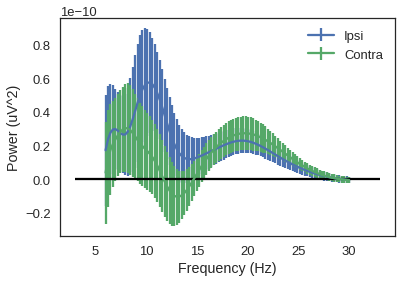

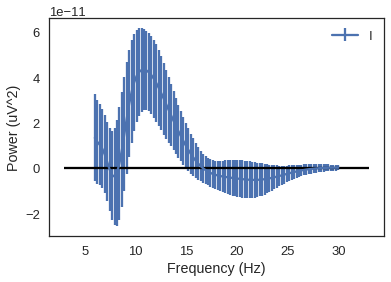

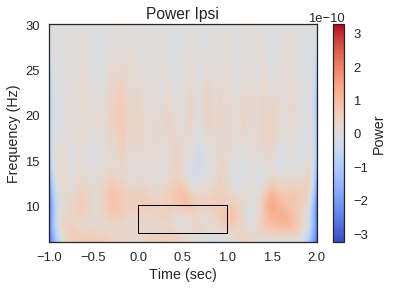

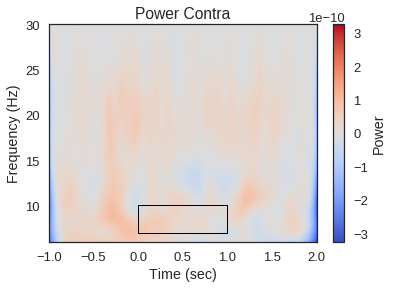

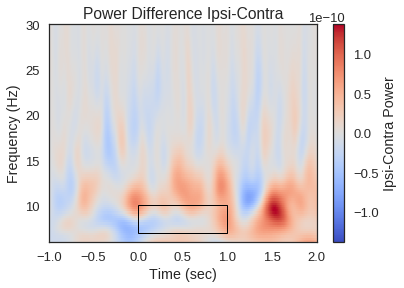

In [6]:
#average spectrograms
GrandAvg_diff = np.nanmean(ERSP_diff_out,0)
GrandAvg_Ipsi = np.nanmean(ERSP_Ipsi_out,0)
GrandAvg_Contra = np.nanmean(ERSP_Contra_out,0)

#average spectra
GrandAvg_spec_Ipsi = np.nanmean(Ipsi_spectra_out,0)
GrandAvg_spec_Contra = np.nanmean(Contra_spectra_out,0)
GrandAvg_spec_diff = np.nanmean(diff_spectra_out,0)

#error bars for spectra (standard error)
num_good = len(diff_out) - sum(np.isnan(diff_out))   
GrandAvg_spec_Ipsi_ste = np.nanstd(Ipsi_spectra_out,0)/np.sqrt(num_good)
GrandAvg_spec_Contra_ste = np.nanstd(Contra_spectra_out,0)/np.sqrt(num_good)
GrandAvg_spec_diff_ste = np.nanstd(diff_spectra_out,0)/np.sqrt(num_good)


##

#Plot Spectra error bars
fig, ax = plt.subplots(1)
plt.errorbar(frequencies,GrandAvg_spec_Ipsi,yerr=GrandAvg_spec_Ipsi_ste)
plt.errorbar(frequencies,GrandAvg_spec_Contra,yerr=GrandAvg_spec_Contra_ste)
plt.legend(('Ipsi','Contra'))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (uV^2)')   
plt.hlines(0,3,33)

#Plot Spectra Diff error bars
fig, ax = plt.subplots(1)
plt.errorbar(frequencies,GrandAvg_spec_diff,yerr=GrandAvg_spec_diff_ste)
plt.legend('Ipsi-Contra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (uV^2)')   
plt.hlines(0,3,33)

##

#Grand Average Ipsi
plot_max = np.max([np.max(np.abs(GrandAvg_Ipsi)), np.max(np.abs(GrandAvg_Contra))])  
fig, ax = plt.subplots(1)
im = plt.imshow(GrandAvg_Ipsi,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Ipsi')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#Grand Average Contra
fig, ax = plt.subplots(1)
im = plt.imshow(GrandAvg_Contra,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Contra')
cb = fig.colorbar(im)
cb.set_label('Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#Grand Average Ipsi-Contra Difference
plot_max_diff = np.max(np.abs(GrandAvg_diff))
fig, ax = plt.subplots(1)
im = plt.imshow(
    ,
           extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max_diff, vmax=plot_max_diff)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Power Difference Ipsi-Contra')
cb = fig.colorbar(im)
cb.set_label('Ipsi-Contra Power')
# Create a Rectangle patch
rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

# Compute T-test 

In [0]:
import scipy
num_good = len(diff_out) - sum(np.isnan(diff_out))

[tstat, pval] = scipy.stats.ttest_ind(diff_out,np.zeros(len(diff_out)),nan_policy='omit')
print('Ipsi Mean: '+  str(np.nanmean(Ipsi_out))) 
print('Contra Mean: '+  str(np.nanmean(Contra_out))) 
print('Mean Diff: '+  str(np.nanmean(diff_out))) 
print('t(' + str(num_good-1) + ') = ' + str(round(tstat,3)))
print('p = ' + str(round(pval,3)))

# Save average powers ipsi and contra


In [7]:
import pandas as pd
print(diff_out)
raw_data = {'Ipsi Power': Ipsi_out, 
        'Contra Power': Contra_out}
df = pd.DataFrame(raw_data, columns = ['Ipsi Power', 'Contra Power'])
print(df)
df.to_csv('375CueingEEG.csv')
print('Saved subject averages for each condition to 375CueingEEG.csv file in present directory')

[nan, 1.7890047693694025e-11, 6.40257192463808e-11, 1.2016988558064774e-10, 1.643681129897095e-10, 1.1465401250727357e-10, 8.107123680349033e-11, -3.1169419915325006e-11, 6.493727108357483e-11, 4.3529314385415755e-11, 2.8760356184521284e-11, 3.773350340044309e-11, 2.1131349959479695e-11, 1.5571207459949601e-10, -4.629115067550113e-10, -8.0522323353216e-11, -4.6644221372820765e-11, nan, nan, -3.4389510978749296e-11, 7.091042185483415e-11, 1.2983383558014348e-11, 1.3604198590381146e-10, -5.861633427481697e-11, -6.204912953285913e-11, 1.8344086913139663e-10, 2.380242500968211e-11, -8.8050332977192e-11, -7.508128947253718e-11, 2.9079648598434818e-11, 2.9079648598434818e-11, -4.146716305783257e-11, -1.5307351374033267e-10, 2.3393198398388223e-11]
      Ipsi Power  Contra Power
0            NaN           NaN
1  -3.901325e-11 -5.690330e-11
2   4.568905e-11 -1.833667e-11
3   2.037251e-11 -9.979737e-11
4   2.567893e-10  9.242117e-11
5   1.128359e-10 -1.818109e-12
6   3.090019e-10  2.279306e-10


# Save Spectra

In [9]:
df = pd.DataFrame(Ipsi_spectra_out,columns=frequencies)
print(df)
df.to_csv('375CueingIpsiSpec.csv')

df = pd.DataFrame(Contra_spectra_out,columns=frequencies)
df.to_csv('375CueingContraSpec.csv')
print('Saved Spectra to 375CueingContraSpec.csv file in present directory')

       6.000000      6.242424      6.484848      6.727273      6.969697   \
0            NaN           NaN           NaN           NaN           NaN   
1   7.991890e-11  8.036284e-11  7.548816e-11  6.696746e-11  5.489871e-11   
2   8.482874e-11  8.635330e-11  9.420775e-11  1.024297e-10  1.064200e-10   
3   1.394826e-10  1.324403e-10  1.241198e-10  1.121430e-10  9.387917e-11   
4   1.355015e-10  1.519385e-10  1.523882e-10  1.378647e-10  1.137803e-10   
5   4.146935e-11  4.747567e-11  5.477697e-11  6.351733e-11  7.302017e-11   
6   1.591767e-10  1.802644e-10  1.960184e-10  2.090976e-10  2.218464e-10   
7   2.051924e-10  1.359738e-10  7.068325e-11  1.696284e-11 -2.275222e-11   
8  -2.289620e-11 -1.966269e-11 -1.143603e-11 -6.869489e-13  1.008869e-11   
9   2.639212e-10  2.390503e-10  2.144125e-10  1.905306e-10  1.680688e-10   
10  1.734091e-10  1.751927e-10  1.753140e-10  1.718332e-10  1.640584e-10   
11 -4.155194e-11  5.554974e-11  1.555793e-10  2.462566e-10  3.218309e-10   
12  1.132429